In [66]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

### iterate through the folders to create a dataframe of the form filepaths labels

In [67]:
sdir=r'/content/awanbaru'

filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths        labels
0  /content/awanbaru/nimbostratus/nimbostratus-34...  nimbostratus
1  /content/awanbaru/nimbostratus/nimbostratus-18...  nimbostratus
2  /content/awanbaru/nimbostratus/nimbostratus-11...  nimbostratus
3  /content/awanbaru/nimbostratus/nimbostratus-41...  nimbostratus
4  /content/awanbaru/nimbostratus/nimbostratus-31...  nimbostratus
labels
nimbostratus     1020
cumulonimbus      933
stratocumulus     865
cumulus           774
stratus           514
Name: count, dtype: int64


### split df into train_df, test_df and valid_df

In [68]:
train_split = 0.7
valid_split = 0.2
test_split = 0.1

# Split pertama untuk mendapatkan train dan dummy (yang akan dibagi lagi menjadi valid dan test)
train_df, dummy_df = train_test_split(df, train_size=train_split, shuffle=True, random_state=123)

# Split kedua untuk mendapatkan validation dan test dari dummy
# Karena dummy_df adalah 30% dari dataset asli, kita bagi validasi 20/30 dan tes 10/30
val_test_ratio = valid_split / (valid_split + test_split)  # 0.2 / (0.2 + 0.1) = 2/3

valid_df, test_df = train_test_split(dummy_df, train_size=val_test_ratio, shuffle=True, random_state=123)

# Print lengths of the splits
print('train_df length: ', len(train_df), '  valid_df length: ', len(valid_df), '  test_df length: ', len(test_df))

# Optional: If you want to reset the indices
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df length:  2874   valid_df length:  821   test_df length:  411


### create train, test, valid  generators

In [73]:
height=224
width=224
channels=3
batch_size=16

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
      rescale=1./255,
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)



test batch size:  3   test steps:  137
Found 2874 validated image filenames belonging to 5 classes.
Found 821 validated image filenames belonging to 5 classes.
Found 411 validated image filenames belonging to 5 classes.
['cumulonimbus', 'cumulus', 'nimbostratus', 'stratocumulus', 'stratus']


### create function to show some image examples

In [74]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

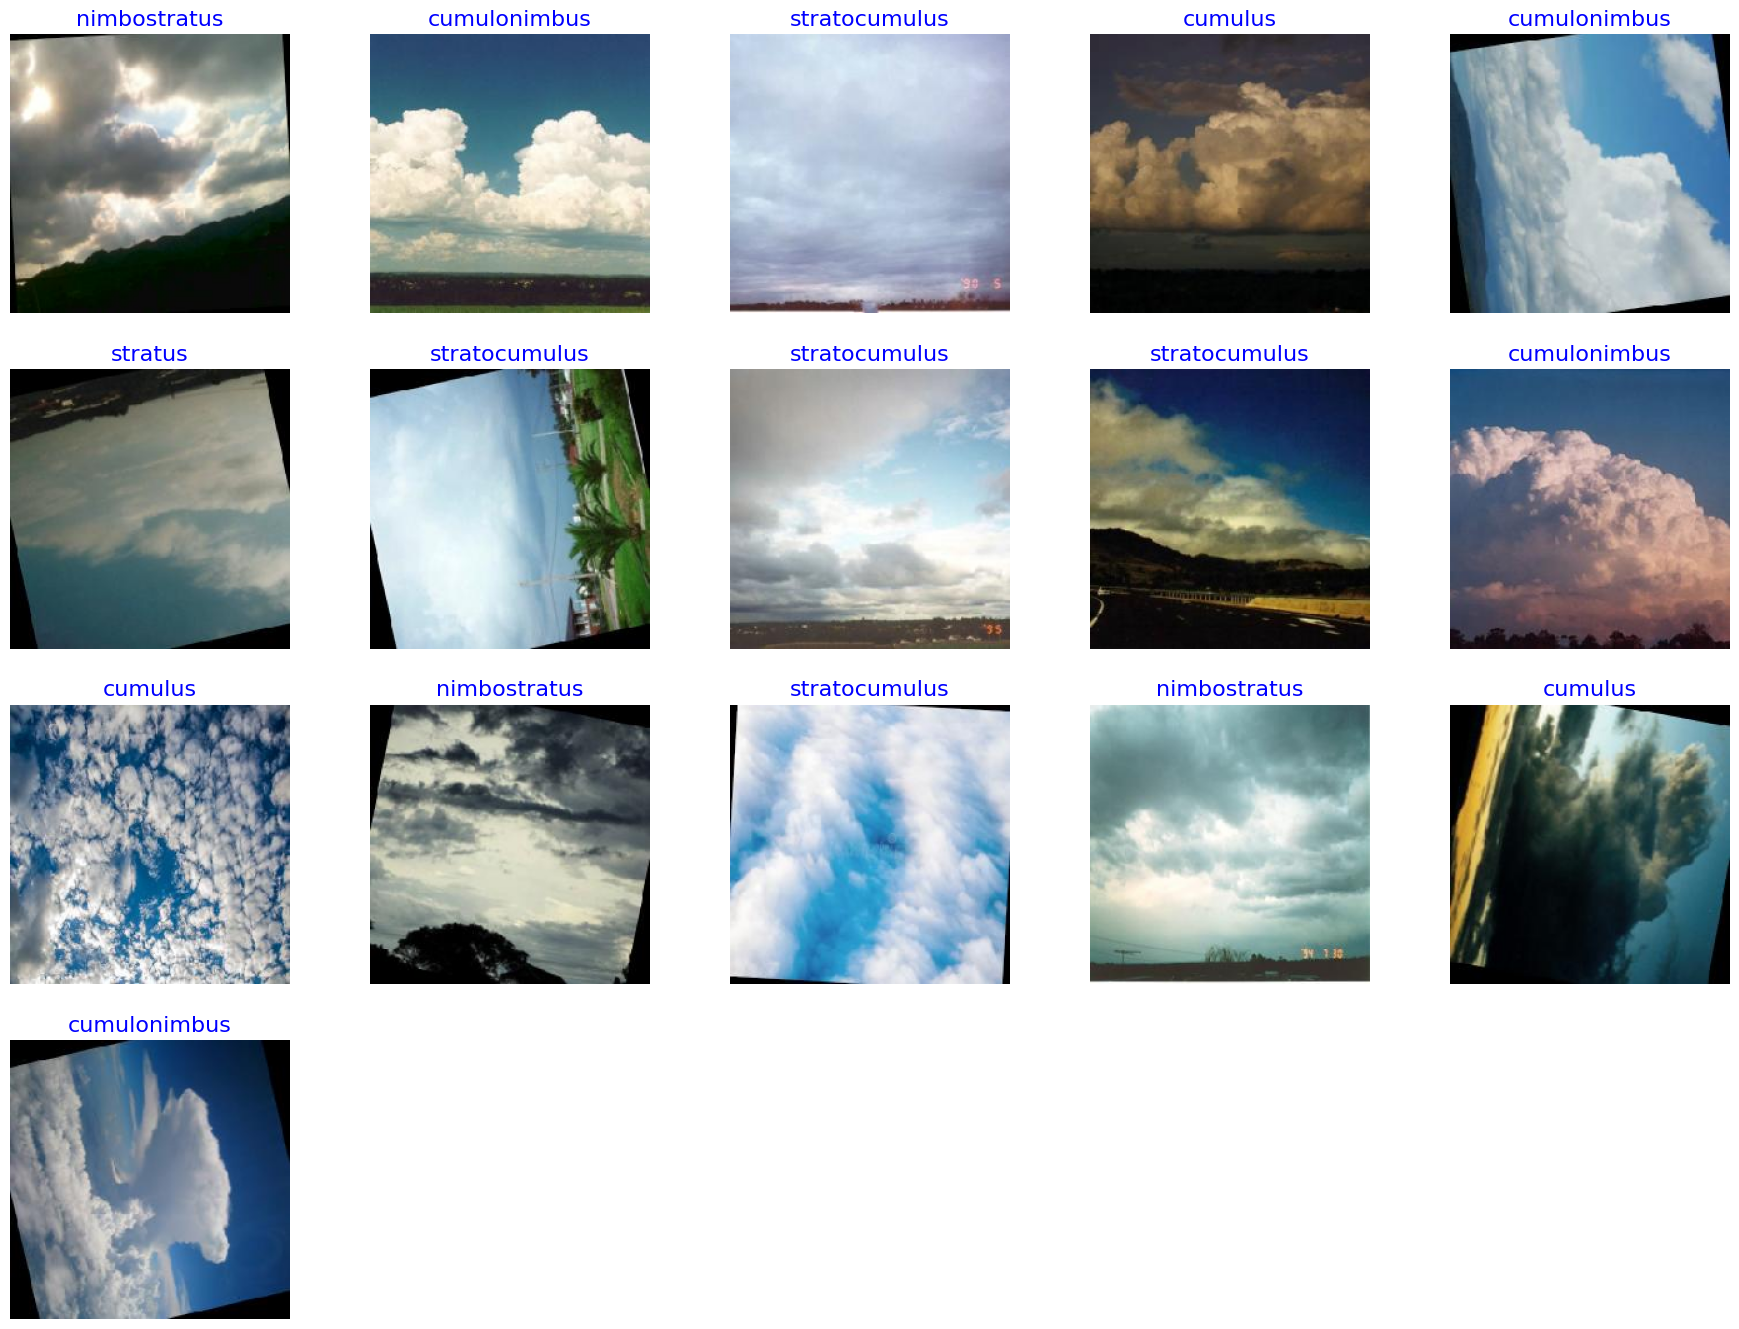

In [75]:
show_image_samples(train_gen)

### create the model

In [89]:
base_model=tf.keras.applications.VGG16(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3)))

In [90]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [91]:
base_model.trainable = False

In [92]:
model_name='Cendekia'
print("Building model with", base_model)
model = tf.keras.Sequential([
            # Note the input shape is the desired size of the image 128x128 with 3 bytes color
            # This is the first convolution
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.src.engine.functional.Functional object at 0x7e0a8275f160>


In [93]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 32)          147488    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 3, 3, 32)          0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 3, 3, 32)          0         
                                                                 
 flatten_7 (Flatten)         (None, 288)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                 1445      
                                                      

In [94]:
epochs =200

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/200
180/180 [==============================] - 23s 121ms/step - loss: 1.4622 - accuracy: 0.3493 - val_loss: 1.2888 - val_accuracy: 0.4555
Epoch 2/200
180/180 [==============================] - 17s 95ms/step - loss: 1.2964 - accuracy: 0.4377 - val_loss: 1.2673 - val_accuracy: 0.4580
Epoch 3/200
180/180 [==============================] - 17s 96ms/step - loss: 1.2257 - accuracy: 0.4729 - val_loss: 1.2243 - val_accuracy: 0.4884
Epoch 4/200
180/180 [==============================] - 17s 96ms/step - loss: 1.1868 - accuracy: 0.4986 - val_loss: 1.1764 - val_accuracy: 0.4933
Epoch 5/200
180/180 [==============================] - 18s 99ms/step - loss: 1.1623 - accuracy: 0.5122 - val_loss: 1.1603 - val_accuracy: 0.5335
Epoch 6/200
180/180 [==============================] - 18s 99ms/step - loss: 1.1056 - accuracy: 0.5296 - val_loss: 1.1469 - val_accuracy: 0.5189
Epoch 7/200
180/180 [==============================] - 18s 100ms/step - loss: 1.0819 - accuracy: 0.5491 - val_loss: 1.1203 - val_

### define function to print text in RGB foreground and background colors

In [95]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

### define function to plot the training data

In [96]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


### define function to generate the confusion matrix and classification report

In [97]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

### evaluate model on the test set then save the model

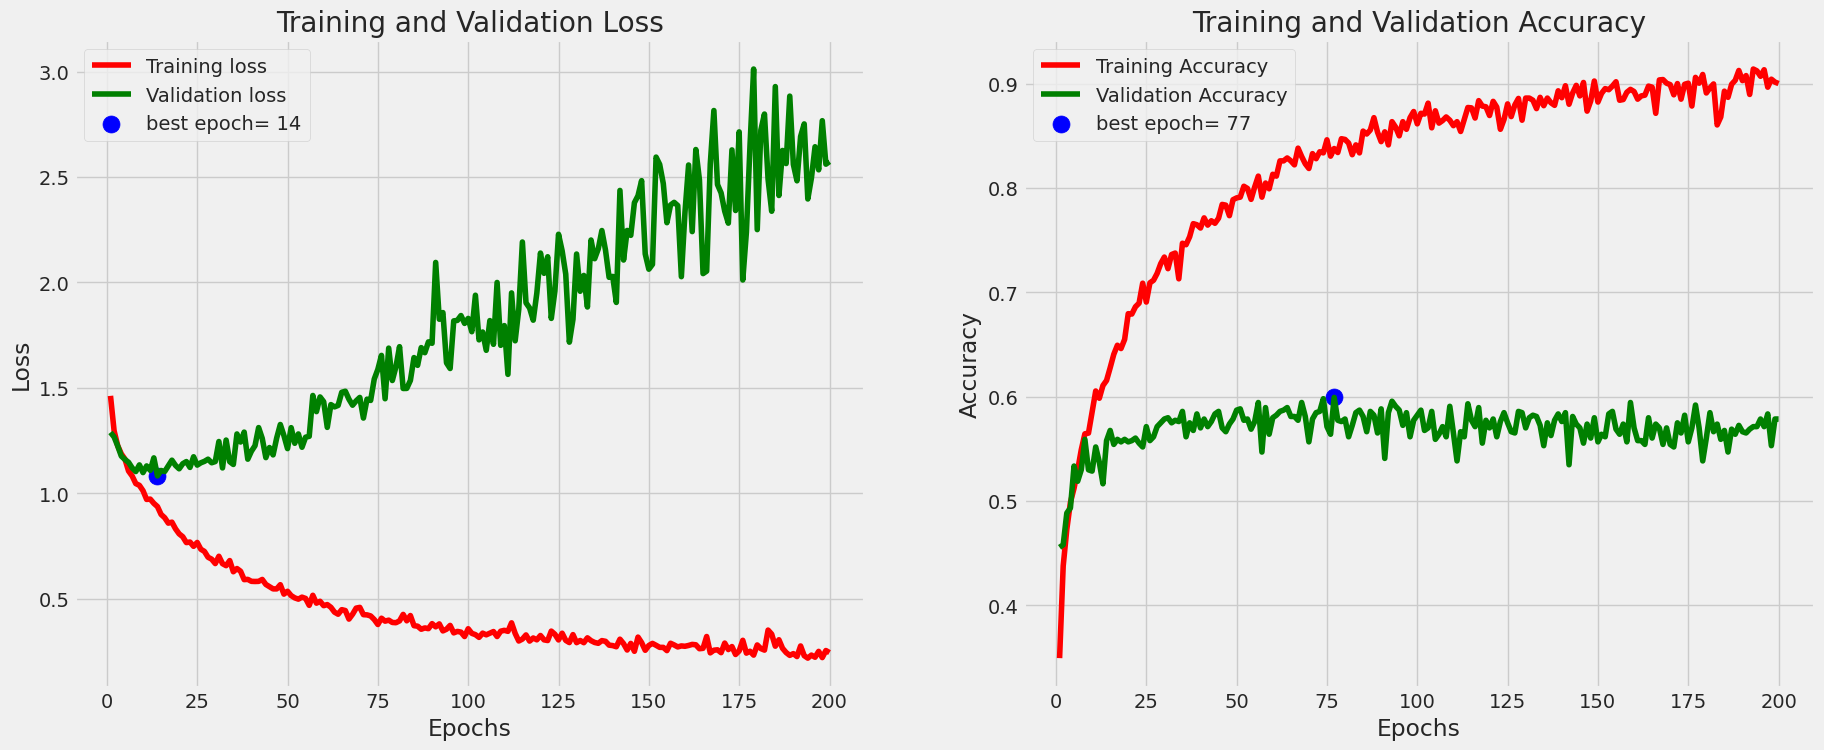

137/137 [==============================] - 4s 21ms/step - loss: 2.5579 - accuracy: 0.5693
accuracy on the test set is 56.93 %



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [98]:
tr_plot(history,0)
save_dir=r'./'
subject='pest'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

### make predictions on test set and generate confusion matrix and classification report

137/137 [==============================] - 3s 21ms/step


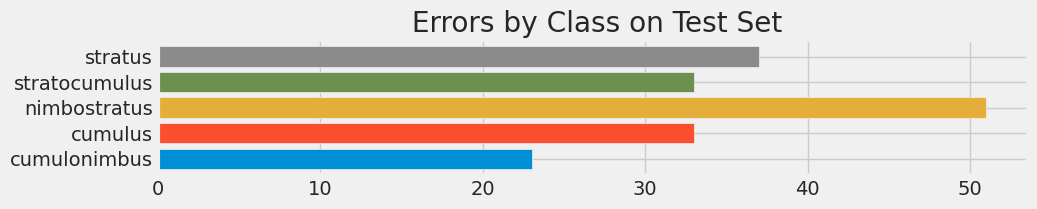

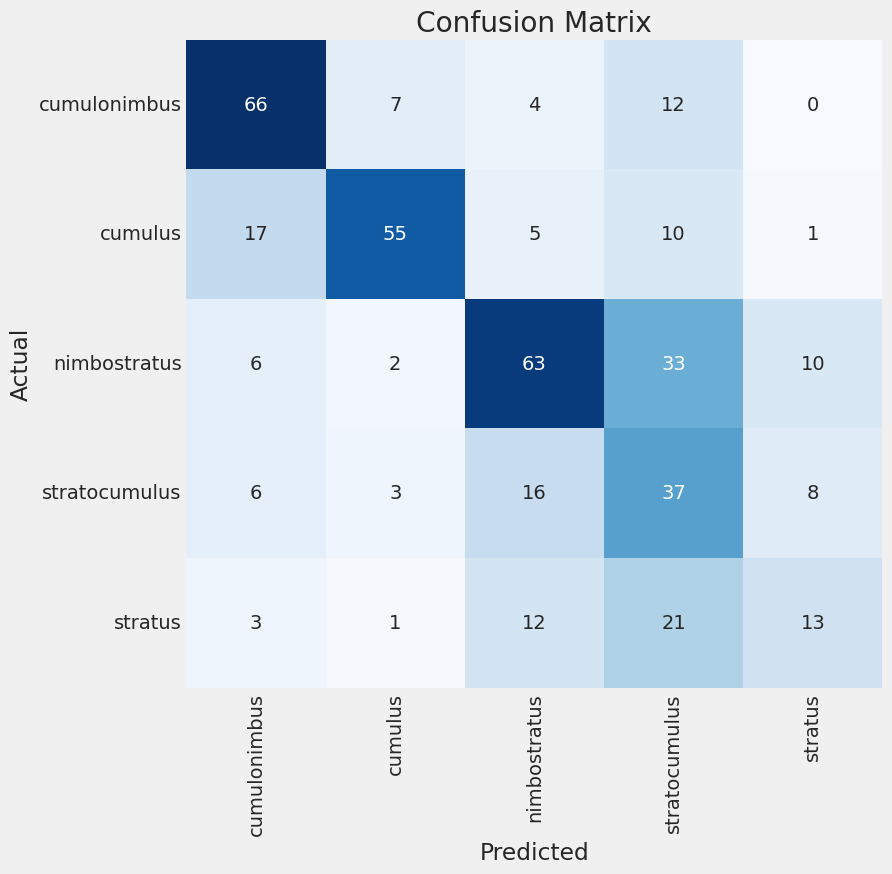

Classification Report:
----------------------
                precision    recall  f1-score   support

 cumulonimbus       0.67      0.74      0.71        89
      cumulus       0.81      0.62      0.71        88
 nimbostratus       0.63      0.55      0.59       114
stratocumulus       0.33      0.53      0.40        70
      stratus       0.41      0.26      0.32        50

     accuracy                           0.57       411
    macro avg       0.57      0.54      0.54       411
 weighted avg       0.60      0.57      0.57       411



In [99]:
print_code=0
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )